In [20]:
from IPython.display import HTML
from pyspark.sql import SQLContext
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcdefaults()
import numpy as np

sqlContext = SQLContext(sc)

def make_movies_dataset(line):
    all_vals = line.split('::')
    temp = line.split('(')
    year = temp[1].split(')')
    return [all_vals[0],all_vals[1],all_vals[2], year[0]]

def make_ratings_dataset(line):
    all_vals = line.split('::')
    return [all_vals[0],all_vals[1],all_vals[2], all_vals[3]]

dataMovies = sc.textFile('./data/movies/movies.csv')
dataRatings = sc.textFile('./data/movies/ratings.csv')
data_df_movies = dataMovies.map(make_movies_dataset).toDF()
data_df_ratings = dataRatings.map(make_ratings_dataset).toDF()
data_df_movies.registerTempTable('movies')
data_df_ratings.registerTempTable('ratings')

#data_df_movies.show()
#print ''
#print 'totaal:'
#print data_df_movies.count()
#print ''
#data_df_ratings.show()
#print ''
#print 'totaal:'
#print data_df_movies.count()

HTML('''<style>.btnExample {
  color: #F9F9FF;
  background: #43D1AF;
  font-weight: bold;
  border: 1px solid #43D1AF;
}
 
.btnExample:hover {
  color: #43D1AF;
  background: #F9F9FF;
}</style><script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input class="btnExample" type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [21]:
options = """<option value='DESC'>Best</option>""" """<option value='ASC'>Worst</option>"""
aantalVar = 1000
choiceVar = "DESC"

input_form_top = """
<style type="text/css">
.form-style-6{
    font: 105% Arial, Helvetica, sans-serif;
    max-width: 400px;
    padding: 16px;
    background: #F7F7F7;
}
.form-style-6 h1{
    background: #43D1AF;
    padding: 20px 0;
    font-size: 150%;
    font-weight: 300;
    text-align: center;
    color: #fff;
    margin: -16px 0px 16px 0px;
}
.form-style-6 input[type="text"],
.form-style-6 input[type="date"],
.form-style-6 input[type="datetime"],
.form-style-6 input[type="email"],
.form-style-6 input[type="number"],
.form-style-6 input[type="search"],
.form-style-6 input[type="time"],
.form-style-6 input[type="url"],
.form-style-6 textarea,
.form-style-6 select 
{
    -webkit-transition: all 0.30s ease-in-out;
    -moz-transition: all 0.30s ease-in-out;
    -ms-transition: all 0.30s ease-in-out;
    -o-transition: all 0.30s ease-in-out;
    outline: none;
    box-sizing: border-box;
    -webkit-box-sizing: border-box;
    -moz-box-sizing: border-box;
    width: 100%;
    background: #fff;
    margin-bottom: 4%;
    border: 1px solid #ccc;
    padding: 3%;
    color: #555;
    font: 95% Arial, Helvetica, sans-serif;
}
.form-style-6 input[type="text"]:focus,
.form-style-6 input[type="date"]:focus,
.form-style-6 input[type="datetime"]:focus,
.form-style-6 input[type="email"]:focus,
.form-style-6 input[type="number"]:focus,
.form-style-6 input[type="search"]:focus,
.form-style-6 input[type="time"]:focus,
.form-style-6 input[type="url"]:focus,
.form-style-6 textarea:focus,
.form-style-6 select:focus
{
    box-shadow: 0 0 5px #43D1AF;
    padding: 3%;
    border: 1px solid #43D1AF;
}

.form-style-6 input[type="submit"],
.form-style-6 input[type="button"]{
    box-sizing: border-box;
    -webkit-box-sizing: border-box;
    -moz-box-sizing: border-box;
    width: 100%;
    padding: 3%;
    background: #43D1AF;
    border-bottom: 2px solid #30C29E;
    border-top-style: none;
    border-right-style: none;
    border-left-style: none;    
    color: #fff;
}
.form-style-6 input[type="submit"]:hover,
.form-style-6 input[type="button"]:hover{
    background: #2EBC99;
}
</style>
<div class="form-style-6">
<h1>Choose order and voting range</h1>
<form>
<select id="var_value">""" + options + """</select>
<input type="number" id="var_aantal"/>
<input type="button" value="Generate" onclick="set_choice()"/>

</form>
</div>
"""
#<div style="background-color:white; border:solid black; width:300px; padding:20px;">
#Choose: <select id="var_value">""" + options + """ </select> <br><br>
#Aantal: <input type="number" id="var_aantal"/> <br><br>

#<button onclick="set_choice()">Go</button>
#</div>

javascript_top = """
<script type="text/Javascript">
    function set_choice(){
        var var_value = document.getElementById('var_value').value;
        var var_aantal = document.getElementById('var_aantal').value;
        var command1 = "choiceVar = '" + var_value + "'";
        var command2 = "aantalVar = '" + var_aantal + "'";
        var kernel = IPython.notebook.kernel;
        kernel.execute(command1);
        kernel.execute(command2);
        IPython.notebook.execute_cell();
    }
</script>
"""

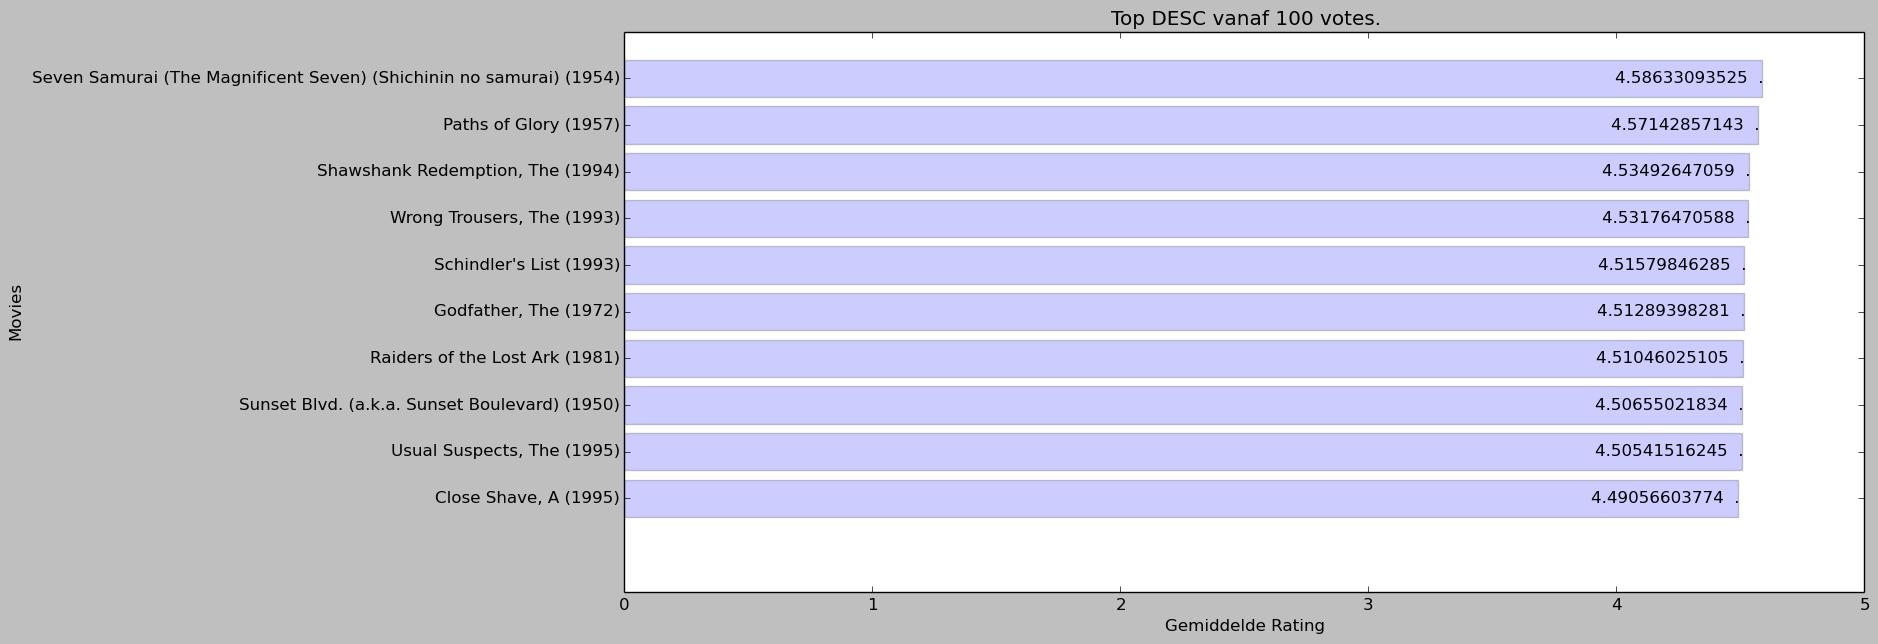

In [23]:
top10Ratings = sqlContext.sql('SELECT (_2) as movieID, AVG(_3) as average FROM ratings GROUP BY _2 HAVING count(_1) > ' +str(aantalVar) + ' ORDER BY average ' +str(choiceVar) +' LIMIT 10')
top10Ratings.registerTempTable('top10Ratings')

top10Movies = sqlContext.sql('SELECT top10Ratings.movieID, movies._2 as movie, top10Ratings.average FROM top10Ratings INNER JOIN movies ON top10Ratings.movieID = movies._1 ORDER BY average')

movie = top10Movies.map(lambda l: l[1]).collect()
y_pos = np.arange(len(movie))
x_pos = top10Movies.map(lambda l: l[2]).collect()

plt.figure(figsize=(16,7))
plt.barh(y_pos, x_pos, align='center', alpha=0.2)
plt.yticks(y_pos, movie)
plt.xlabel('Gemiddelde Rating')
plt.ylabel('Movies')
plt.title('Top ' + str(choiceVar) +' vanaf ' +str(aantalVar) +' votes.')


for x, y in zip(x_pos, y_pos):
    plt.text(x, y, str(x)+"  .", ha='right', va='center')
    
plt.show()
HTML(input_form_top + javascript_top)


In [4]:
userID = '1'
movie = sqlContext.sql('SELECT ratings._2 as movieID, AVG(ratings._3) as average FROM ratings GROUP BY ratings._2')
movie.registerTempTable('movie')

input_form_user = """
<style type="text/css">
.form-style-6{
    font: 105% Arial, Helvetica, sans-serif;
    max-width: 400px;
    padding: 16px;
    background: #F7F7F7;
}
.form-style-6 h1{
    background: #43D1AF;
    padding: 20px 0;
    font-size: 150%;
    font-weight: 300;
    text-align: center;
    color: #fff;
    margin: -16px 0px 16px 0px;
}
.form-style-6 input[type="text"],
.form-style-6 input[type="date"],
.form-style-6 input[type="datetime"],
.form-style-6 input[type="email"],
.form-style-6 input[type="number"],
.form-style-6 input[type="search"],
.form-style-6 input[type="time"],
.form-style-6 input[type="url"],
.form-style-6 textarea,
.form-style-6 select 
{
    -webkit-transition: all 0.30s ease-in-out;
    -moz-transition: all 0.30s ease-in-out;
    -ms-transition: all 0.30s ease-in-out;
    -o-transition: all 0.30s ease-in-out;
    outline: none;
    box-sizing: border-box;
    -webkit-box-sizing: border-box;
    -moz-box-sizing: border-box;
    width: 100%;
    background: #fff;
    margin-bottom: 4%;
    border: 1px solid #ccc;
    padding: 3%;
    color: #555;
    font: 95% Arial, Helvetica, sans-serif;
}
.form-style-6 input[type="text"]:focus,
.form-style-6 input[type="date"]:focus,
.form-style-6 input[type="datetime"]:focus,
.form-style-6 input[type="email"]:focus,
.form-style-6 input[type="number"]:focus,
.form-style-6 input[type="search"]:focus,
.form-style-6 input[type="time"]:focus,
.form-style-6 input[type="url"]:focus,
.form-style-6 textarea:focus,
.form-style-6 select:focus
{
    box-shadow: 0 0 5px #43D1AF;
    padding: 3%;
    border: 1px solid #43D1AF;
}

.form-style-6 input[type="submit"],
.form-style-6 input[type="button"]{
    box-sizing: border-box;
    -webkit-box-sizing: border-box;
    -moz-box-sizing: border-box;
    width: 100%;
    padding: 3%;
    background: #43D1AF;
    border-bottom: 2px solid #30C29E;
    border-top-style: none;
    border-right-style: none;
    border-left-style: none;    
    color: #fff;
}
.form-style-6 input[type="submit"]:hover,
.form-style-6 input[type="button"]:hover{
    background: #2EBC99;
}
</style>
<div class="form-style-6">
<h1>Select user ID</h1>
<form>
<input type="number" id="var_userID"/> 
<input type="button" value="Go" onclick="set_userID()"/>

</form>
</div>
"""


#UserID: <input type="number" id="var_userID"/> 

#<button onclick="set_userID()">Go</button>
#</div>

javascript_user = """
<script type="text/Javascript">
    function set_userID(){
        var var_userID = document.getElementById('var_userID').value;
        var command = "userID = '" + var_userID + "'";
        var kernel = IPython.notebook.kernel;
        kernel.execute(command);
        IPython.notebook.execute_cell();
    }
</script>
"""

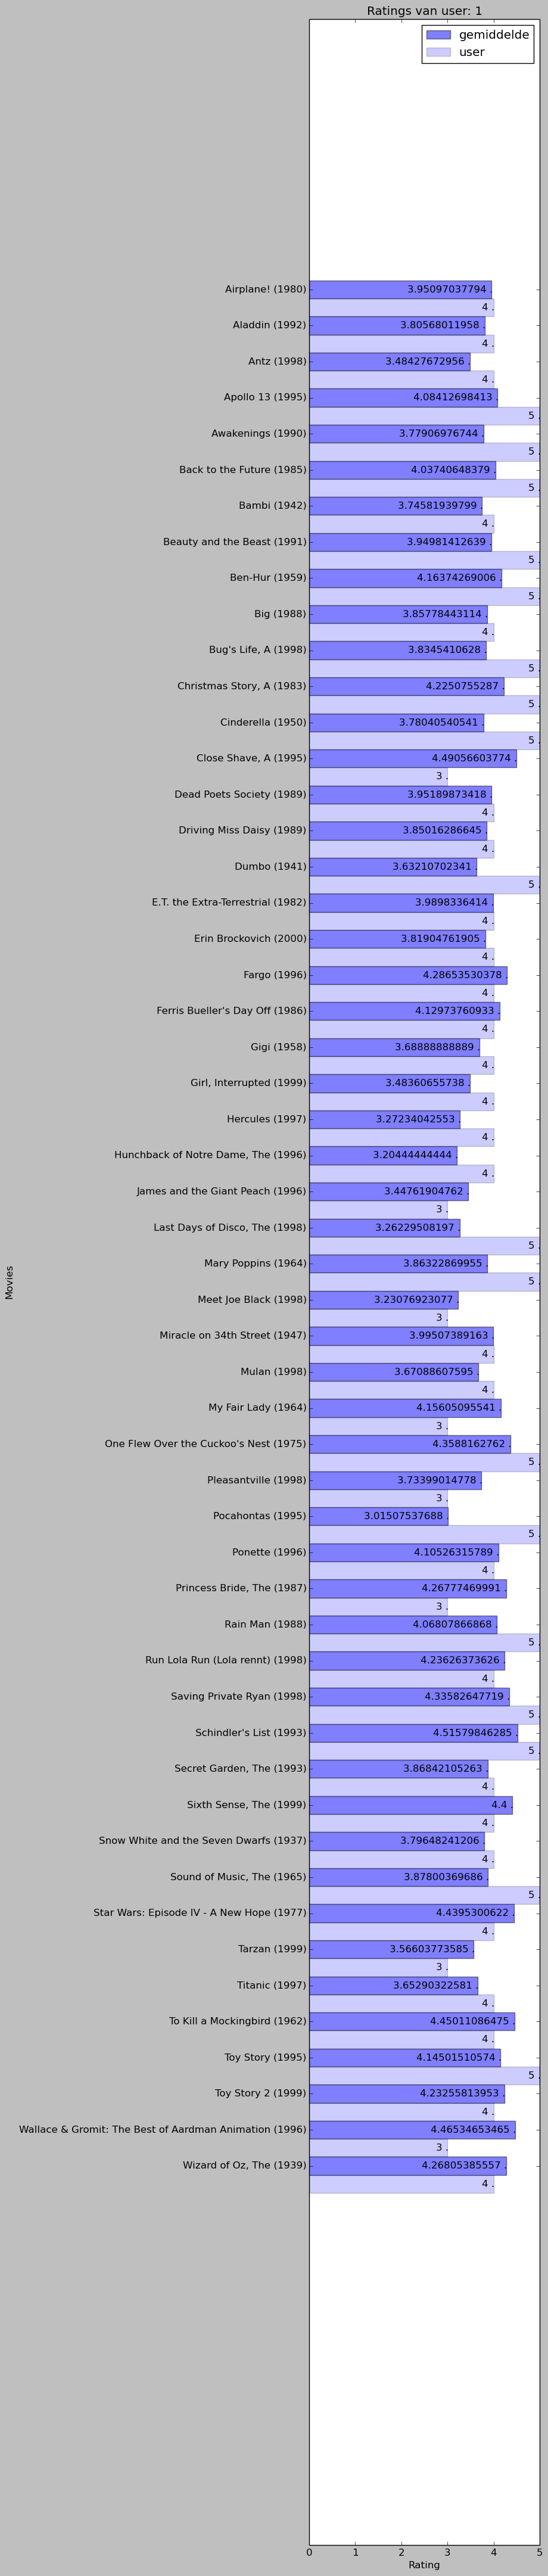

In [5]:
user = sqlContext.sql('SELECT movies._1 as movieID, movies._2 as movie, ratings._3 as rating FROM ratings INNER JOIN movies ON ratings._2 = movies._1 WHERE ratings._1 = ' +str(userID))
user.registerTempTable('user')
resultaat = sqlContext.sql('SELECT user.movie, user.rating, movie.average FROM user INNER JOIN movie ON user.movieID = movie.movieID ORDER BY movie DESC')

width = 0.5

movie = resultaat.map(lambda l: l[0]).collect()
y_pos = np.arange(len(movie))
x_pos_user = resultaat.map(lambda l: int(l[1])).collect()
x_pos_movie = resultaat.map(lambda l: l[2]).collect()

fig, ax = plt.subplots(figsize=(5, width * 2 * len(y_pos)))

rects1 = ax.barh(y_pos, x_pos_user, width, align='center', alpha = 0.2)
rects2 = ax.barh(y_pos + width, x_pos_movie, width, align='center', alpha = 0.5)

ax.set_yticks(y_pos + width)
ax.set_yticklabels(movie)
ax.set_xlabel('Rating')
ax.set_ylabel('Movies')
ax.set_title('Ratings van user: ' +str(userID))

ax.legend((rects2[0], rects1[0]), ('gemiddelde', 'user'))


for x, y in zip(x_pos_user, y_pos):
    ax.text(x, y, str(x) +' .', ha='right', va='center')

for x, y in zip(x_pos_movie, y_pos + width):
    ax.text(x, y, str(x) +' .', ha='right', va='center')

plt.show()
HTML(input_form_user + javascript_user)

In [6]:
movieID = '1'
moviesSql = sqlContext.sql('SELECT _1,_2 FROM movies')
movies = moviesSql.map(lambda l: l[0]).collect()
moviesTitle = moviesSql.map(lambda l: l[1]).collect()

options = ''

i=0;
for x in movies:
    options += """<option value='""" + str(x) + """'>""" + moviesTitle[i] + """</option>"""
    i += 1
input_form_movie = """
<style type="text/css">
.form-style-6{
    font: 105% Arial, Helvetica, sans-serif;
    max-width: 400px;
    padding: 16px;
    background: #F7F7F7;
}
.form-style-6 h1{
    background: #43D1AF;
    padding: 20px 0;
    font-size: 150%;
    font-weight: 300;
    text-align: center;
    color: #fff;
    margin: -16px 0px 16px 0px;
}
.form-style-6 input[type="text"],
.form-style-6 input[type="date"],
.form-style-6 input[type="datetime"],
.form-style-6 input[type="email"],
.form-style-6 input[type="number"],
.form-style-6 input[type="search"],
.form-style-6 input[type="time"],
.form-style-6 input[type="url"],
.form-style-6 textarea,
.form-style-6 select 
{
    -webkit-transition: all 0.30s ease-in-out;
    -moz-transition: all 0.30s ease-in-out;
    -ms-transition: all 0.30s ease-in-out;
    -o-transition: all 0.30s ease-in-out;
    outline: none;
    box-sizing: border-box;
    -webkit-box-sizing: border-box;
    -moz-box-sizing: border-box;
    width: 100%;
    background: #fff;
    margin-bottom: 4%;
    border: 1px solid #ccc;
    padding: 3%;
    color: #555;
    font: 95% Arial, Helvetica, sans-serif;
}
.form-style-6 input[type="text"]:focus,
.form-style-6 input[type="date"]:focus,
.form-style-6 input[type="datetime"]:focus,
.form-style-6 input[type="email"]:focus,
.form-style-6 input[type="number"]:focus,
.form-style-6 input[type="search"]:focus,
.form-style-6 input[type="time"]:focus,
.form-style-6 input[type="url"]:focus,
.form-style-6 textarea:focus,
.form-style-6 select:focus
{
    box-shadow: 0 0 5px #43D1AF;
    padding: 3%;
    border: 1px solid #43D1AF;
}

.form-style-6 input[type="submit"],
.form-style-6 input[type="button"]{
    box-sizing: border-box;
    -webkit-box-sizing: border-box;
    -moz-box-sizing: border-box;
    width: 100%;
    padding: 3%;
    background: #43D1AF;
    border-bottom: 2px solid #30C29E;
    border-top-style: none;
    border-right-style: none;
    border-left-style: none;    
    color: #fff;
}
.form-style-6 input[type="submit"]:hover,
.form-style-6 input[type="button"]:hover{
    background: #2EBC99;
}
</style>
<div class="form-style-6">
<h1>Select movie</h1>
<form>
<select id="var_movie">""" + options + """</select>
<input type="button" value="set movie" onclick="set_movie()"/>
</form>
</div>
"""

javascript_movie = """
<script type="text/Javascript">
    function set_movie(){
        var var_movie = document.getElementById('var_movie').value;
        var command = "movieID = '" + var_movie + "'";
        var kernel = IPython.notebook.kernel;
        kernel.execute(command);
        IPython.notebook.execute_cell();
    }
</script>
"""


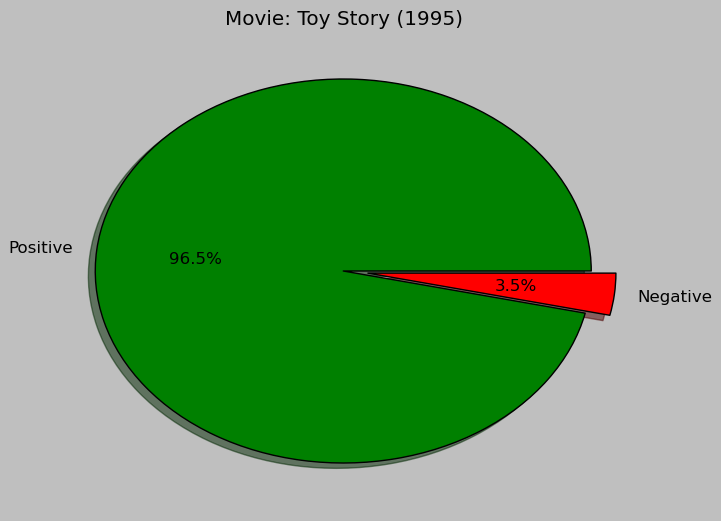

In [24]:

ratingsMovie = sqlContext.sql('SELECT ratings._3 as rating FROM ratings WHERE ratings._2 = "' +str(movieID) +'" ORDER BY rating DESC')
ratingsMovie.registerTempTable('ratingsMovie')
positiveRatings = sqlContext.sql('SELECT COUNT(rating) AS positive FROM ratingsMovie WHERE rating >= 2.5')
negativeRatings = sqlContext.sql('SELECT COUNT(rating) AS negative FROM ratingsMovie WHERE rating < 2.5')
movieTitle = sqlContext.sql('SELECT _2 FROM movies WHERE _1 = ' +str(movieID)).map(lambda l: l[0]).collect()

labels = 'Positive', 'Negative'
explode = (0, 0.1)
sizes = [positiveRatings.map(lambda l: l[0]).collect(), negativeRatings.map(lambda l: l[0]).collect() ]
colors = ['green', 'red']
plt.title('Movie: ' + movieTitle[0] )


plt.pie(sizes, labels = labels, colors=colors, explode = explode, shadow = True, autopct='%1.1f%%')

plt.show()
HTML(input_form_movie + javascript_movie)

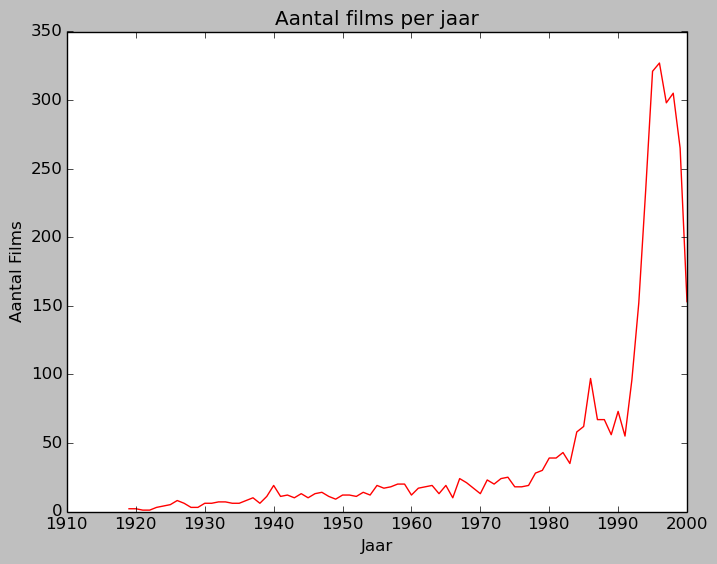

In [8]:
moviesql = sqlContext.sql('select distinct _4,count(_4) from movies where _4 like "19%" or _4 like "20%" group by _4 order by _4')
#moviesql.show()
moviesql.registerTempTable('movieyears')

movie_radius = moviesql.map(lambda l: l[0]).collect()
movie_area = moviesql.map(lambda l: l[1]).collect()

plot = plt.plot(movie_radius, movie_area, 'r')

plt.xlabel('Jaar')
plt.ylabel('Aantal Films')
plt.title('Aantal films per jaar')


plt.show()

In [9]:
options = """<option value='Fantasy'>Fantasy</option>""" """<option value='Action'>Action</option>""" """<option value='Adventure'>Adventure</option>""" """<option value='Children's'>Children's</option>""" """<option value='Drama'>Drama</option>""" """<option value='Crime'>Crime</option>""" """<option value='Comedy'>Comedy</option>""" """<option value='Romance'>Romance</option>""" """<option value='Documentary'>Documentary</option>""" """<option value='Mystery'>Mystery</option>""" """<option value='Sci-Fi'>Sci-Fi</option>""" """<option value='War'>War</option>""" """<option value='Horror'>Horror</option>""" """<option value='Thriller'>Thriller</option>""" """<option value='Musical'>Musical</option>""" """<option value='Film-Noir'>Film-Noir</option>"""
genreVar = 'Fantasy'

input_form_genre = """
<style type="text/css">
.form-style-6{
    font: 105% Arial, Helvetica, sans-serif;
    max-width: 400px;
    padding: 16px;
    background: #F7F7F7;
}
.form-style-6 h1{
    background: #43D1AF;
    padding: 20px 0;
    font-size: 150%;
    font-weight: 300;
    text-align: center;
    color: #fff;
    margin: -16px 0px 16px 0px;
}
.form-style-6 input[type="text"],
.form-style-6 input[type="date"],
.form-style-6 input[type="datetime"],
.form-style-6 input[type="email"],
.form-style-6 input[type="number"],
.form-style-6 input[type="search"],
.form-style-6 input[type="time"],
.form-style-6 input[type="url"],
.form-style-6 textarea,
.form-style-6 select 
{
    -webkit-transition: all 0.30s ease-in-out;
    -moz-transition: all 0.30s ease-in-out;
    -ms-transition: all 0.30s ease-in-out;
    -o-transition: all 0.30s ease-in-out;
    outline: none;
    box-sizing: border-box;
    -webkit-box-sizing: border-box;
    -moz-box-sizing: border-box;
    width: 100%;
    background: #fff;
    margin-bottom: 4%;
    border: 1px solid #ccc;
    padding: 3%;
    color: #555;
    font: 95% Arial, Helvetica, sans-serif;
}
.form-style-6 input[type="text"]:focus,
.form-style-6 input[type="date"]:focus,
.form-style-6 input[type="datetime"]:focus,
.form-style-6 input[type="email"]:focus,
.form-style-6 input[type="number"]:focus,
.form-style-6 input[type="search"]:focus,
.form-style-6 input[type="time"]:focus,
.form-style-6 input[type="url"]:focus,
.form-style-6 textarea:focus,
.form-style-6 select:focus
{
    box-shadow: 0 0 5px #43D1AF;
    padding: 3%;
    border: 1px solid #43D1AF;
}

.form-style-6 input[type="submit"],
.form-style-6 input[type="button"]{
    box-sizing: border-box;
    -webkit-box-sizing: border-box;
    -moz-box-sizing: border-box;
    width: 100%;
    padding: 3%;
    background: #43D1AF;
    border-bottom: 2px solid #30C29E;
    border-top-style: none;
    border-right-style: none;
    border-left-style: none;    
    color: #fff;
}
.form-style-6 input[type="submit"]:hover,
.form-style-6 input[type="button"]:hover{
    background: #2EBC99;
}
</style>
<div class="form-style-6">
<h1>Pick a Country</h1>
<form>
<select id="var_value1">""" + options + """</select>
<input type="button" value="Set genre" onclick="set_value()"/>
</form>
</div>
"""




javascript = """
<script type="text/Javascript">
    function set_value(){
        var var_value1 = document.getElementById('var_value1').value;
        var command = "genreVar = '" + var_value1 + "'";
        var kernel = IPython.notebook.kernel;
        kernel.execute(command);
        IPython.notebook.execute_cell();
    }
</script>
"""

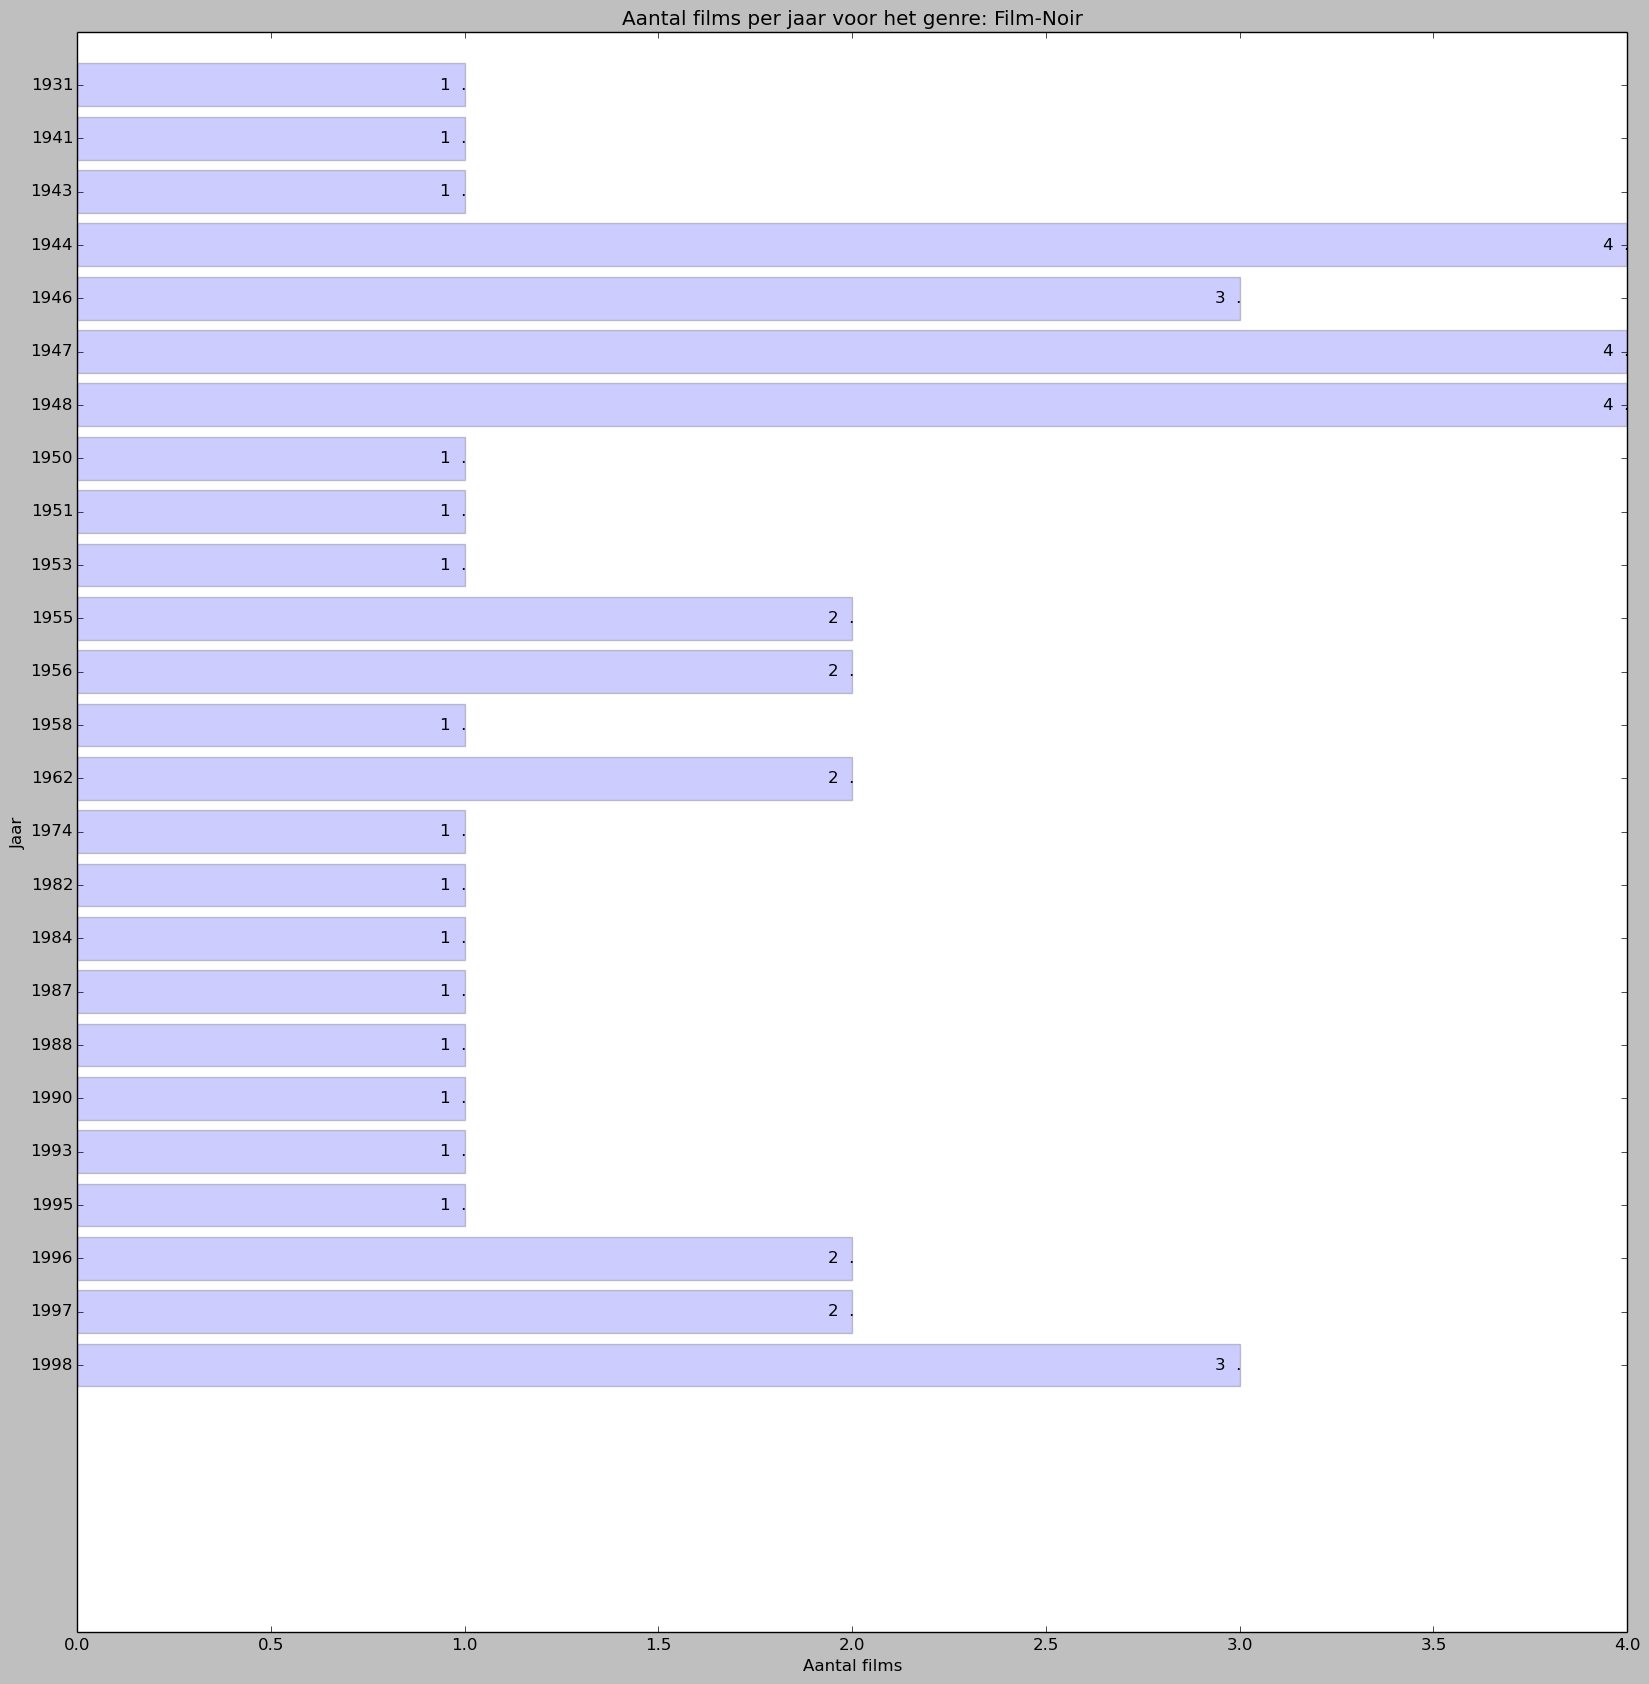

In [25]:
genresql = sqlContext.sql('select distinct (_4),count(_3) as aantal  from movies where (_4 like "19%" or _4 like "20%") AND (_3 like "%' + str(genreVar)+'" or _3 like "%' + str(genreVar)+'%" or _3 like "%' + str(genreVar)+'") group by _4 order by _4 DESC')
#genresql.show()


genre = genresql.map(lambda l: l[0]).collect()
y_pos = np.arange(len(genre))
x_pos = genresql.map(lambda l: l[1]).collect()


plt.figure(figsize=(20,20))
plt.barh(y_pos, x_pos, align='center', alpha=0.2)
plt.yticks(y_pos, genre)
plt.xlabel('Aantal films')
plt.ylabel('Jaar')
plt.title('Aantal films per jaar voor het genre: ' + str(genreVar))


for x, y in zip(x_pos, y_pos):
    plt.text(x, y, str(x)+"  .", ha='right', va='center')
    
plt.show()

HTML(input_form_genre + javascript)